In [1]:
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import json
import matplotlib.pyplot as plt 
from rdkit.Chem.rdChemReactions import CreateDifferenceFingerprintForReaction
from rdkit.Chem import rdChemReactions
import matplotlib
import seaborn as sns 
from sklearn.feature_selection import VarianceThreshold

font = {'family' : 'normal',
        'size'   : 25}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_style("white")
%matplotlib inline 

In [3]:
import os 
os.getcwd()

'/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/rxnprediction/DFT_for_SM'

In [5]:
df_dataset = pd.read_csv('data_csv/rxn_dataset.csv')
df_suzuki = pd.read_csv('data_csv/suz_hte_rxn_smarts_updated.csv')
df_bh = pd.read_csv('data_csv/bh_hte_rxnfp.csv')

In [6]:
rxnfp_dataset = np.array([json.loads(x) for x in df_dataset.rxnfp])
rxnfp_suzuki = np.array([json.loads(x) for x in df_suzuki.rxnfp])
rxnfp_bh = np.array([json.loads(x) for x in df_bh.rxnfp])

In [7]:
rxnfp_dataset = np.array([list(CreateDifferenceFingerprintForReaction(rdChemReactions.ReactionFromSmarts(x.replace('>.', '>').replace('.>', '>')))) for x in df_dataset.RXN])
rxnfp_suzuki = np.array([list(CreateDifferenceFingerprintForReaction(rdChemReactions.ReactionFromSmarts(x.replace('C(C)(C)C).', 'C(C)(C)C.').replace('>.', '>').replace('.>', '>')))) for x in df_suzuki.rxn_smarts])
rxnfp_bh = np.array([list(CreateDifferenceFingerprintForReaction(rdChemReactions.ReactionFromSmarts(x))) for x in df_bh.rxn_smarts])

In [16]:
classes = ['Ni-CO coupling', 'Suzuki HTE', 'Buchwald-Hartwig HTE']


In [21]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

rxnfps = np.concatenate((rxnfp_dataset, rxnfp_suzuki, rxnfp_bh), axis=0)
labels = np.concatenate(([0] * len(rxnfp_dataset), [1] * len(rxnfp_suzuki), [2] * len(rxnfp_bh)))
weights = np.concatenate(([1/len(rxnfp_dataset)] * len(rxnfp_dataset), [1/len(rxnfp_suzuki)] * len(rxnfp_suzuki), [1/len(rxnfp_bh)] * len(rxnfp_bh)))
classes = ['Ni-CO coupling', 'Suzuki HTE', 'Buchwald-Hartwig HTE']

"""
selector = VarianceThreshold()

transformed = tsne.fit_transform(selector.fit_transform(weights.reshape(-1, 1) * rxnfps))
projected_dataset = transformed[:len(rxnfp_dataset), :]
projected_suzuki = transformed[len(rxnfp_dataset):-len(rxnfp_bh), :]
projected_bh = transformed[-len(rxnfp_bh):, :]

"""

transformed = pca.fit_transform(weights.reshape(-1, 1) * rxnfps)
projected_dataset_pca = transformed[:len(rxnfp_dataset), :]
projected_suzuki_pca = transformed[len(rxnfp_dataset):-len(rxnfp_bh), :]
projected_bh_pca = transformed[-len(rxnfp_bh):, :]


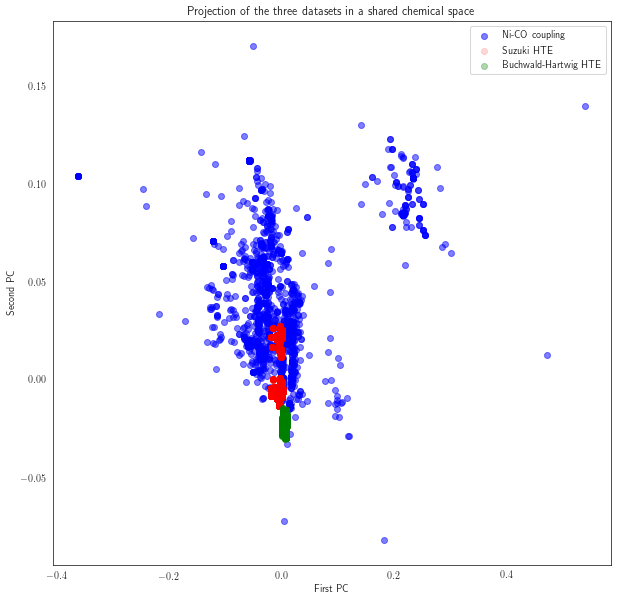

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))


# produce a legend with the unique colors from the scatter

ax.scatter(projected_dataset_pca[:, 0], projected_dataset_pca[:, 1], c='b', label=classes[0], alpha=0.5)
ax.scatter(projected_suzuki_pca[:, 0], projected_suzuki_pca[:, 1], c='r', label=classes[1], alpha=0.15)
ax.scatter(projected_bh_pca[:, 0], projected_bh_pca[:, 1], c='g', label=classes[2], alpha=0.3)
ax.set_title("Projection of the three datasets in a shared chemical space")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")

ax.legend()


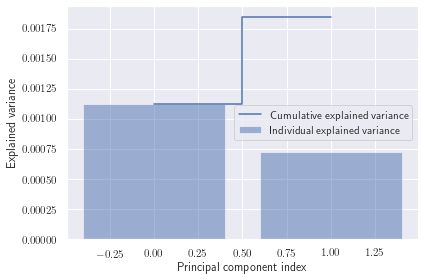

In [122]:
exp_var_pca = pca.explained_variance_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Similarity plots 

In [11]:
from scipy.spatial import distance
distance.jaccard([1, 0, 0], [0, 1, 0])

distances = []
dataset = []

for rxn in rxnfp_dataset:
    indices = np.random.choice(rxnfp_dataset.shape[0], 25, replace=False)
    for rxn_alternative in rxnfp_dataset[indices]:
        distances.append(distance.jaccard(rxn, rxn_alternative))
        dataset.append("Ni-CO coupling")
        
for rxn in rxnfp_suzuki:
    indices = np.random.choice(rxnfp_suzuki.shape[0], 25, replace=False)
    for rxn_alternative in rxnfp_suzuki[indices]:
        distances.append(distance.jaccard(rxn, rxn_alternative))
        dataset.append("Suzuki HTE")
        
for rxn in rxnfp_bh:
    indices = np.random.choice(rxnfp_bh.shape[0], 25, replace=False)
    for rxn_alternative in rxnfp_bh[indices]:
        distances.append(distance.jaccard(rxn, rxn_alternative))
        dataset.append("Buchwald-Hartwig HTE")

df = pd.DataFrame(zip(distances, dataset), columns = ['Distance', 'Dataset',])

KeyboardInterrupt: 

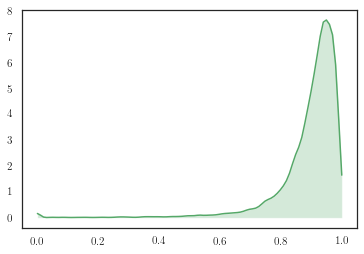

In [145]:
from scipy.stats import norm

#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Ni-CO coupling")[0]], density=True, facecolor='g', alpha=0.75, label="Ni-CO coupling")
x = np.array(distances)[np.where(np.array(dataset)=="Ni-CO coupling")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
plt.fill_between(x_d, density, alpha=0.25, facecolor='g')
plt.plot(x_d, density, color='g', label="Ni-CO coupling")

x = np.array(distances)[np.where(np.array(dataset)=="Suzuki HTE")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
plt.fill_between(x_d, density, alpha=0.25, facecolor='b')
plt.plot(x_d, density, color='b', label="Suzuki HTE")

x = np.array(distances)[np.where(np.array(dataset)=="Buchwald-Hartwig HTE")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
plt.fill_between(x_d, density, alpha=0.25, facecolor='darkorange')
plt.plot(x_d, density, color='darkorange', label="Buchwald-Hartwig HTE")


#density = sum(norm(xi).pdf(x_d) for xi in x)
#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Suzuki HTE")[0]], density=True, facecolor='b', alpha=0.5, label="Suzuki HTE")
#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Buchwald-Hartwig HTE")[0]], density=True, facecolor='y', alpha=0.25, label="Buchwald-Hartwig HTE")

plt.xlabel('Jaccard distance')
plt.ylabel('Density')
plt.title('Jaccard distance distributions')

plt.grid(True)
plt.legend(loc=2)
plt.show()

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

rxnfps = np.concatenate((rxnfp_dataset, rxnfp_suzuki, rxnfp_bh), axis=0)
labels = np.concatenate(([0] * len(rxnfp_dataset), [1] * len(rxnfp_suzuki), [2] * len(rxnfp_bh)))

#indices = np.random.choice(range(len(rxnfps)), 2500)
indices = range(len(rxnfps))
similarities = euclidean_distances(rxnfps[indices, :])

mds = MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    dissimilarity="precomputed")

pos = mds.fit(similarities).embedding_


In [26]:
pos *= np.sqrt((rxnfps[indices, :] ** 2).sum()) / np.sqrt((pos ** 2).sum())

In [29]:
projected_dataset = pos[np.where(labels[indices]==0)[0], :]
projected_suzuki = pos[np.where(labels[indices]==1)[0], :]
projected_bh = pos[np.where(labels[indices]==2)[0], :]

In [15]:
sns.color_palette("bright")


[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [38]:
df

,x,y
0,-67.757386,177.771040
1,-28.849049,180.521042
2,-203.983466,231.357861
3,-17.085389,556.799529
4,-23.859993,157.241906
...,...,...
408,-114.554144,239.438610
409,-91.231241,194.614719
410,185.550669,-72.147372
411,249.631541,-123.679471


In [64]:
!pip install seaborn>=0.12

You should consider upgrading via the 'pip install --upgrade pip' command.


TypeError: _bivariate_kdeplot() got multiple values for argument 'x'

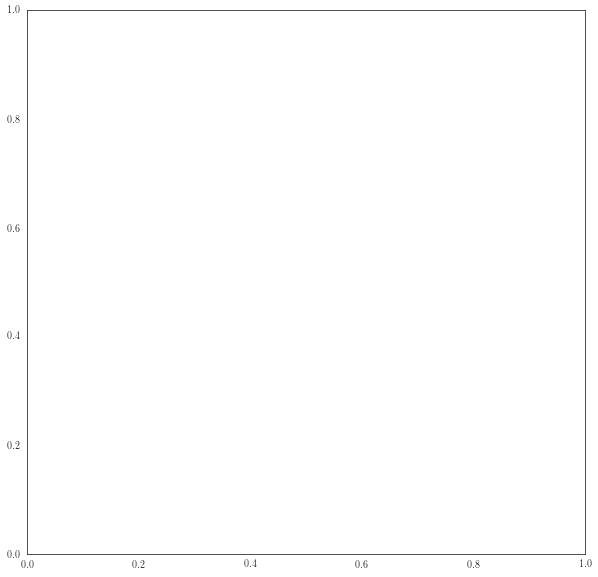

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))


# produce a legend with the unique colors from the scatter
"""sns.kdeplot(data=Suz_df, x="TSNE 1", y="TSNE 2",
            fill=True, thresh=0.05,
            color='blue', gridsize=100,
            alpha = 0.4, linewidth=50,
           levels =5, ax=ax)
"""

df = pd.DataFrame(list(zip(projected_dataset[:, 0], projected_dataset[:, 1])),
               columns =['mds1', 'mds2'])

sns.kdeplot(data=df, x="mds1", y="mds2",
            fill=True,
            color='blue', gridsize=100,
            alpha = 0.4, linewidth=50,
           levels =5, ax=ax)

"""
sns.kdeplot(x="x", y="y", data=df,
                fill=True, thresh=0.05,
            color='blue', gridsize=100,
            alpha = 0.4, linewidth=50,
           levels =5, ax=ax)
"""

sns.scatterplot(x=projected_dataset[:, 0], y=projected_dataset[:, 1], 
                alpha=0.8, 
                palette='bright', linewidth=0.1, ax=ax)

#ax.scatter(projected_dataset[:, 0], projected_dataset[:, 1], c='b', label=classes[0], alpha=0.5)
#ax.scatter(projected_suzuki[:, 0], projected_suzuki[:, 1], c='orange', label=classes[1], alpha=0.5)
#ax.scatter(projected_bh[:, 0], projected_bh[:, 1], c='g', label=classes[2], alpha=0.5)
ax.set_title("Projection of the three datasets in a shared chemical space with Multi-Dimensional Scaling", fontsize=20)
ax.set_xlabel("MDS 1", fontsize=20)
ax.set_ylabel("MDS 2", fontsize=20)

ax.legend(fontsize=20)


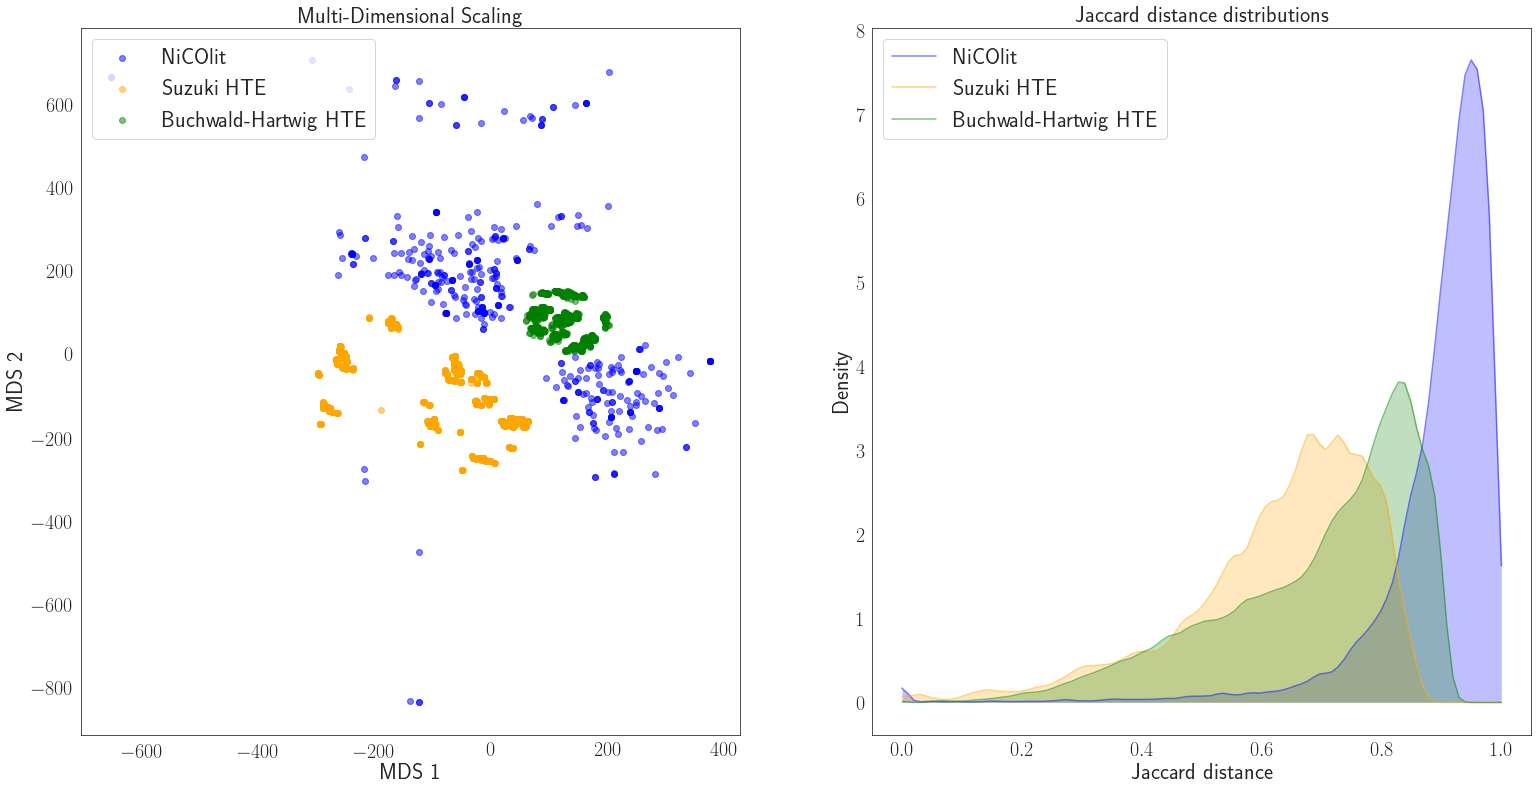

In [32]:
from scipy.stats import norm

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(26, 13))


"""
ax1.scatter(projected_dataset_pca[:, 0], projected_dataset_pca[:, 1], c='b', label=classes[0], alpha=0.5)
ax1.scatter(projected_suzuki_pca[:, 0], projected_suzuki_pca[:, 1], c='orange', label=classes[1], alpha=0.5)
ax1.scatter(projected_bh_pca[:, 0], projected_bh_pca[:, 1], c='g', label=classes[2], alpha=0.5)
ax1.set_title("Principal Component Analysis", fontsize=22)
ax1.set_xlabel("First PC", fontsize=22)
ax1.set_ylabel("Second PC", fontsize=22)
ax1.grid(True)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.legend(loc=2, fontsize=22)
"""

ax2.scatter(projected_dataset[:, 0], projected_dataset[:, 1], c='b', label="NiCOlit", alpha=0.5)
ax2.scatter(projected_suzuki[:, 0], projected_suzuki[:, 1], c='orange', label=classes[1], alpha=0.5)
ax2.scatter(projected_bh[:, 0], projected_bh[:, 1], c='g', label=classes[2], alpha=0.5)
ax2.set_title("Multi-Dimensional Scaling", fontsize=22)
ax2.set_xlabel("MDS 1", fontsize=22)
ax2.set_ylabel("MDS 2", fontsize=22)
#ax2.grid(True)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.legend(loc=2, fontsize=22)


x = np.array(distances)[np.where(np.array(dataset)=="Ni-CO coupling")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
ax3.fill_between(x_d, density, alpha=0.25, facecolor='b')
ax3.plot(x_d, density, color='b', label="NiCOlit", alpha=0.5)

x = np.array(distances)[np.where(np.array(dataset)=="Suzuki HTE")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
ax3.fill_between(x_d, density, alpha=0.25, facecolor='orange')
ax3.plot(x_d, density, color='orange', label="Suzuki HTE", alpha=0.5)

x = np.array(distances)[np.where(np.array(dataset)=="Buchwald-Hartwig HTE")[0]]
x_d = np.linspace(0, 1, 100)
density = sum(norm(xi, 0.01).pdf(x_d) for xi in x) / len(x)
ax3.fill_between(x_d, density, alpha=0.25, facecolor='g')
ax3.plot(x_d, density, color='g', label="Buchwald-Hartwig HTE", alpha=0.5)


#density = sum(norm(xi).pdf(x_d) for xi in x)
#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Suzuki HTE")[0]], density=True, facecolor='b', alpha=0.5, label="Suzuki HTE")
#plt.hist(np.array(distances)[np.where(np.array(dataset)=="Buchwald-Hartwig HTE")[0]], density=True, facecolor='y', alpha=0.25, label="Buchwald-Hartwig HTE")

ax3.set_xlabel('Jaccard distance', fontsize=22)
ax3.set_ylabel('Density', fontsize=22)
ax3.set_title('Jaccard distance distributions', fontsize=22)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
#ax3.grid(True)
ax3.legend(loc=2, fontsize=22)


In [20]:
pos

array([[  1.42192636,   6.51328142],
       [  1.42192636,   6.51328142],
       [  1.42192636,   6.51328142],
       ...,
       [-10.07511343,   8.49379196],
       [-13.24313585,   4.07348881],
       [-10.7911201 ,   1.62691008]])

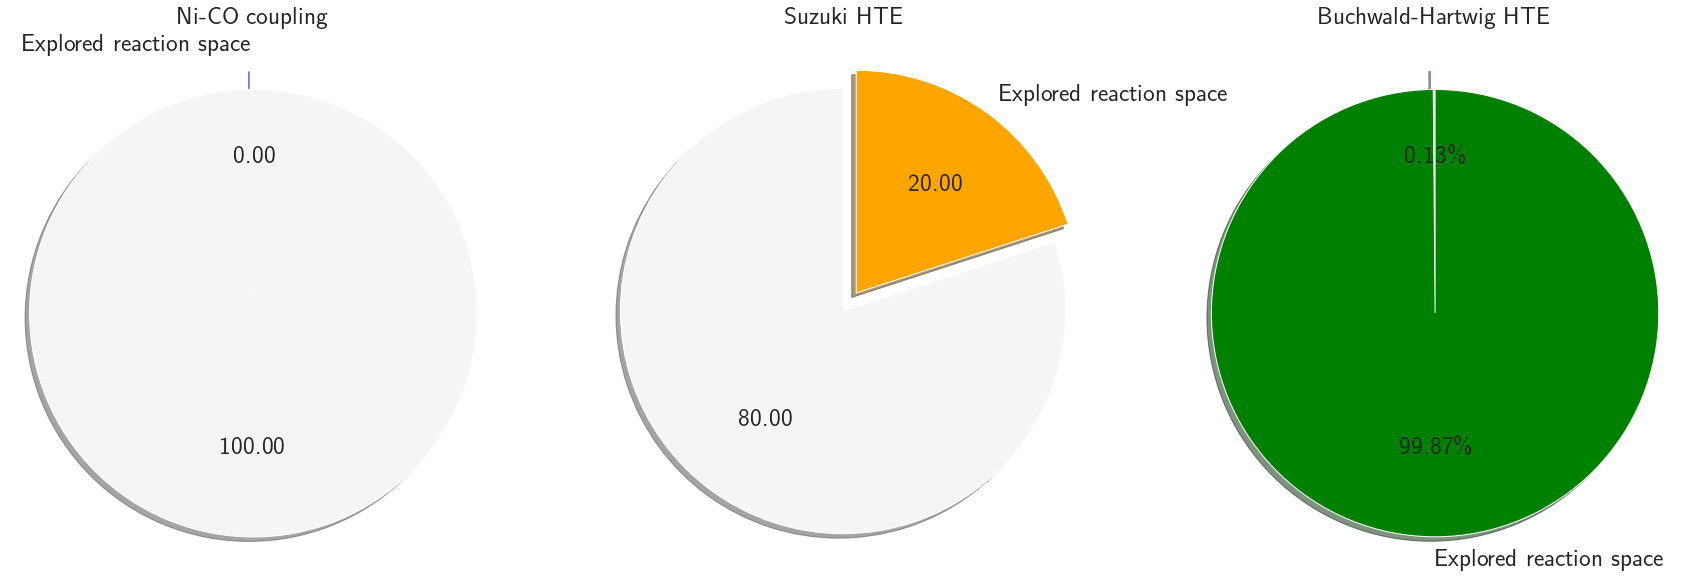

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '', 'Explored reaction space'
sizes = [100 - 1.1*1e-9, 1.1*1e-9]
sizes = [1.5*1e12, 1717]
explode = (0, 0.1,)  # only "explode" the 2nd slice (i.e. 'Hogs')
ax1.set_title("Ni-CO coupling",  fontdict ={'fontsize': 25})
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(sizes)/100 :.0f} items',
        shadow=True, startangle=90,  textprops={'fontsize': 25}, colors=["whitesmoke", "b"])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

labels = '', 'Explored reaction space'
sizes = [80, 20]
explode = (0, 0.1,)  # only "explode" the 2nd slice (i.e. 'Hogs')
ax2.set_title("Suzuki HTE",  fontdict ={'fontsize': 25})
ax2.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(sizes)/100 :.0f} items',
        shadow=True, startangle=90,  textprops={'fontsize': 25}, colors=["whitesmoke", "orange"])
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# add a circle at the center to transform it in a donut chart


labels = '', 'Explored reaction space'
sizes = [0.13, 99.87]
explode = (0, 0.1,)  # only "explode" the 2nd slice (i.e. 'Hogs')
ax3.set_title("Buchwald-Hartwig HTE",  fontdict ={'fontsize': 25})
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.2f\%%',
        shadow=True, startangle=90,  textprops={'fontsize': 25}, colors=["whitesmoke", "g"])
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

/site/rp/work/projects/DD/Anaconda4AI/anaconda3/envs/torch_env/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


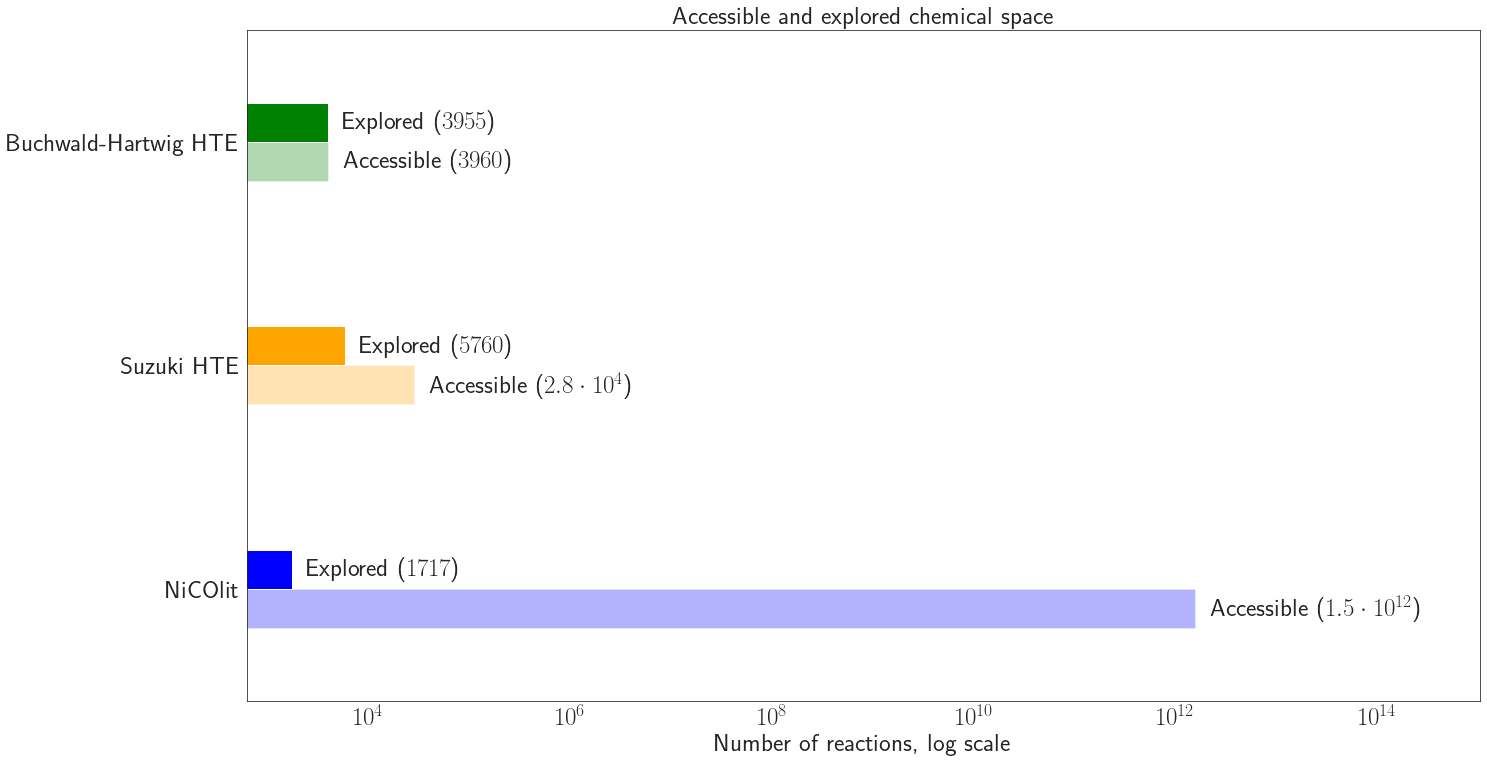

In [63]:
import matplotlib.transforms as transforms


labels = ['NiCOlit', 'Suzuki HTE', 'Buchwald-Hartwig HTE',]

available_reactions = [1.5*1e12, 2.8*1e4, 3960]
available_reactions_labels = ["$1.5  \cdot 10^{12}$", "$2.8  \cdot 10^4$", "$3960$"]

existing_reactions = [1717, 5760, 3955]

existing_reactions_labels = ["$1717$", "$5760$", "$3955$"]


ind = np.arange(2* len(available_reactions), step=2) 

ind = np.array([1, 3, 5])
# the x locations for the groups
width = 0.35  # the width of the bars



fig, ax = plt.subplots(figsize = (20, 10))


rects1 = ax.barh(ind - width/2, available_reactions, width,
                label='Accessible reactions', color=["b", "orange", 'g'], alpha=0.3)
rects2 = ax.barh(ind + width/2, existing_reactions, width,  
                label='Explored reactions',color=["b", "orange", 'g'],)

# Add some text for labels, title and custom x-axis tick labels, etc.




for i, rect in enumerate(rects1):
    width = rect.get_width()
    x_value = rect.get_width() + rect.get_x()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 15 
    plt.annotate(
        "Accessible (" + available_reactions_labels[i] + ")",                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha="left", fontsize = 25)
    

    #plt.text(x_value, y_value, "Accessible" , ha='center', va='bottom', fontdict ={'fontsize': 25})

for i, rect in enumerate(rects2):
    width = rect.get_width()
    x_value = rect.get_width() + rect.get_x()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 15 
    plt.annotate(
        "Explored (" + existing_reactions_labels[i] + ")",                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha="left", fontsize = 25)

fig.tight_layout()

ax.set_xlabel('Number of reactions, log scale', fontdict ={'fontsize': 25})
ax.set_title('Accessible and explored chemical space', fontdict ={'fontsize': 25})
plt.xscale('log')
ax.set_ylim(0, 6)
ax.set_xlim(0, 1e15)

ax.set_yticks(ind)
ax.set_yticklabels(labels, fontdict ={'fontsize': 25})
ax.tick_params(axis='both', which='major', labelsize=25)


plt.show()